LaTeX macros (hidden cell)
$
\newcommand{\Q}{\mathcal{Q}}
\newcommand{\ECov}{\boldsymbol{\Sigma}}
\newcommand{\EMean}{\boldsymbol{\mu}}
\newcommand{\EAlpha}{\boldsymbol{\alpha}}
\newcommand{\EBeta}{\boldsymbol{\beta}}
$

# Imports and configuration

In [1]:
import sys
import os
import re
import datetime as dt

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *

from notebook.services.config import ConfigManager

from portfolio_tools import data_download, DataReader, compute_inputs

In [2]:
# Version checks
print(sys.version)
print('matplotlib: {}'.format(matplotlib.__version__))

# Jupyter configuration
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})  

# Numpy options
np.set_printoptions(precision=5, linewidth=120, suppress=True)

# Pandas options
pd.set_option('display.max_rows', None)

# Matplotlib options
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
matplotlib: 3.3.4


# Prepare input data

Here we load the raw data that will be used to compute the optimization input variables, the vector $\EMean$ of expected returns and the covariance matrix $\ECov$. The data consists of daily stock prices of $8$ stocks from the US market. 

## Download data

In [3]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data. 
# The code can be modified to download from other sources. To be able to run the examples, 
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock. 
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18, 
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
list_stocks = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
list_factors = []
alphaToken = None
 
list_tickers = list_stocks + list_factors
if alphaToken is not None:
    data_download(list_tickers, alphaToken)  

## Read data

We load the daily stock price data from the downloaded CSV files. The data is adjusted for splits and dividends. Then a selected time period is taken from the data.

In [4]:
investment_start = "2016-03-18"
investment_end = "2021-03-18"

In [5]:
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", symbol_list=list_tickers)
dr.read_data()
df_prices, _ = dr.get_period(start_date=investment_start, end_date=investment_end)

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv

Using data files: 
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_LMT.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_CSCO.csv



# Run the optimization

## Define the optimization model

Below we implement the optimization model in Fusion API. We create it inside a function so we can call it later.

In [6]:
def EfficientFrontier(N, m, G, deltas):

    with Model("Case study") as M:
        # Settings
        #M.setLogHandler(sys.stdout)
        
        # Variables 
        # The variable x is the fraction of holdings in each security. 
        # It is restricted to be positive, which imposes the constraint of no short-selling.   
        x = M.variable("x", N, Domain.greaterThan(0.0))
        
        # The variable s models the portfolio variance term in the objective.
        s = M.variable("s", 1, Domain.unbounded())
    
        # Budget constraint
        M.constraint('budget', Expr.sum(x), Domain.equalsTo(1))
        
        # Objective (quadratic utility version)
        delta = M.parameter()
        M.objective('obj', ObjectiveSense.Maximize, Expr.sub(Expr.dot(m, x), Expr.mul(delta, s)))

        # Conic constraint for the portfolio variance
        M.constraint('risk', Expr.vstack(s, Expr.mul(G.transpose(), x)), Domain.inQCone())
        
        # Create DataFrame to store the results. Last security name (the SPY) is removed.
        columns = ["delta", "obj", "return", "risk"] + df_prices.columns.tolist()
        df_result = pd.DataFrame(columns=columns)
        for d in deltas:
            # Update parameter
            delta.setValue(d);
            
            # Solve optimization
            M.solve()
            
            # Save results
            portfolio_return = m @ x.level()
            portfolio_risk = s.level()[0]
            row = pd.Series([d, M.primalObjValue(), portfolio_return, portfolio_risk] + list(x.level()), index=columns)
            df_result = df_result.append(row, ignore_index=True)

        return df_result

## Compute optimization input variables

Here we use the loaded daily price data to compute the corresponding yearly mean return and covariance matrix.

In [7]:
# Number of securities
N = df_prices.shape[1]  

# Get optimization parameters
m_orig, S_orig = compute_inputs(df_prices, shrinkage=False)
m_shrunk, S_shrunk = compute_inputs(df_prices, shrinkage=True)

Next we compute the matrix $G$ such that $\ECov=GG^\mathsf{T}$, this is the input of the conic form of the optimization problem. Here we use Cholesky factorization.

In [8]:
G_orig = np.linalg.cholesky(S_orig)  
G_shrunk = np.linalg.cholesky(S_shrunk)

## Call the optimizer function

We run the optimization for a range of risk aversion parameter values: $\delta = 10^{-1},\dots,10^{1.5}$. We compute the efficient frontier this way both with and without using shrinkage estimation. 

In [9]:
# Compute efficient frontier with and without shrinkage
deltas = np.logspace(start=-1, stop=1.5, num=20)[::-1]
df_result_orig = EfficientFrontier(N, m_orig, G_orig, deltas)
df_result_shrunk = EfficientFrontier(N, m_shrunk, G_shrunk, deltas)

# Set small negatives to zero to make plotting work
mask = df_result_orig < 0
mask.iloc[:, :-8] = False
df_result_orig[mask] = 0

# Set small negatives to zero to make plotting work
mask = df_result_shrunk < 0
mask.iloc[:, :-8] = False
df_result_shrunk[mask] = 0

Check the results without shrinkage.

In [10]:
df_result_orig

,delta,obj,return,risk,PM,LMT,MCD,MMM,AAPL,MSFT,TXN,CSCO
0,31.622777,-6.271623,0.175479,0.203875,1.028265e-01,1.130694e-01,3.006178e-01,1.649833e-01,1.858580e-09,7.935826e-02,5.704450e-02,1.821003e-01
1,23.357215,-4.586052,0.178755,0.203997,9.909667e-02,1.126087e-01,3.000667e-01,1.591047e-01,4.924156e-09,8.752507e-02,6.125146e-02,1.803467e-01
2,17.252105,-3.340046,0.183200,0.204221,9.403794e-02,1.119876e-01,2.993066e-01,1.511270e-01,1.591124e-08,9.860883e-02,6.696296e-02,1.779691e-01
3,12.742750,-2.418350,0.189246,0.204634,8.715598e-02,1.111417e-01,2.982779e-01,1.402758e-01,1.260082e-08,1.136854e-01,7.472952e-02,1.747337e-01
4,9.412050,-1.735700,0.197502,0.205396,7.775956e-02,1.099847e-01,2.968750e-01,1.254593e-01,7.724432e-09,1.342709e-01,8.533623e-02,1.703143e-01
5,6.951928,-1.228921,0.208856,0.206817,6.483617e-02,1.083978e-01,2.949459e-01,1.050808e-01,2.034727e-08,1.625818e-01,9.991937e-02,1.642383e-01
6,5.134833,-0.851059,0.224685,0.209499,4.681660e-02,1.061779e-01,2.922631e-01,7.667410e-02,1.098705e-08,2.020499e-01,1.202504e-01,1.557680e-01
7,3.792690,-0.566941,0.247845,0.214831,1.987816e-02,1.033735e-01,2.885324e-01,3.622285e-02,4.703605e-03,2.559474e-01,1.478737e-01,1.434684e-01
8,2.801357,-0.349680,0.277674,0.223947,3.671098e-09,9.021648e-02,2.674048e-01,9.172596e-09,2.610527e-02,3.244756e-01,1.773813e-01,1.144165e-01
9,2.069138,-0.181326,0.312261,0.238547,2.982460e-09,5.163382e-02,2.062153e-01,2.614700e-10,5.362076e-02,4.289136e-01,2.091390e-01,5.047755e-02


## Visualize the results

Plot the efficient frontier for both cases.

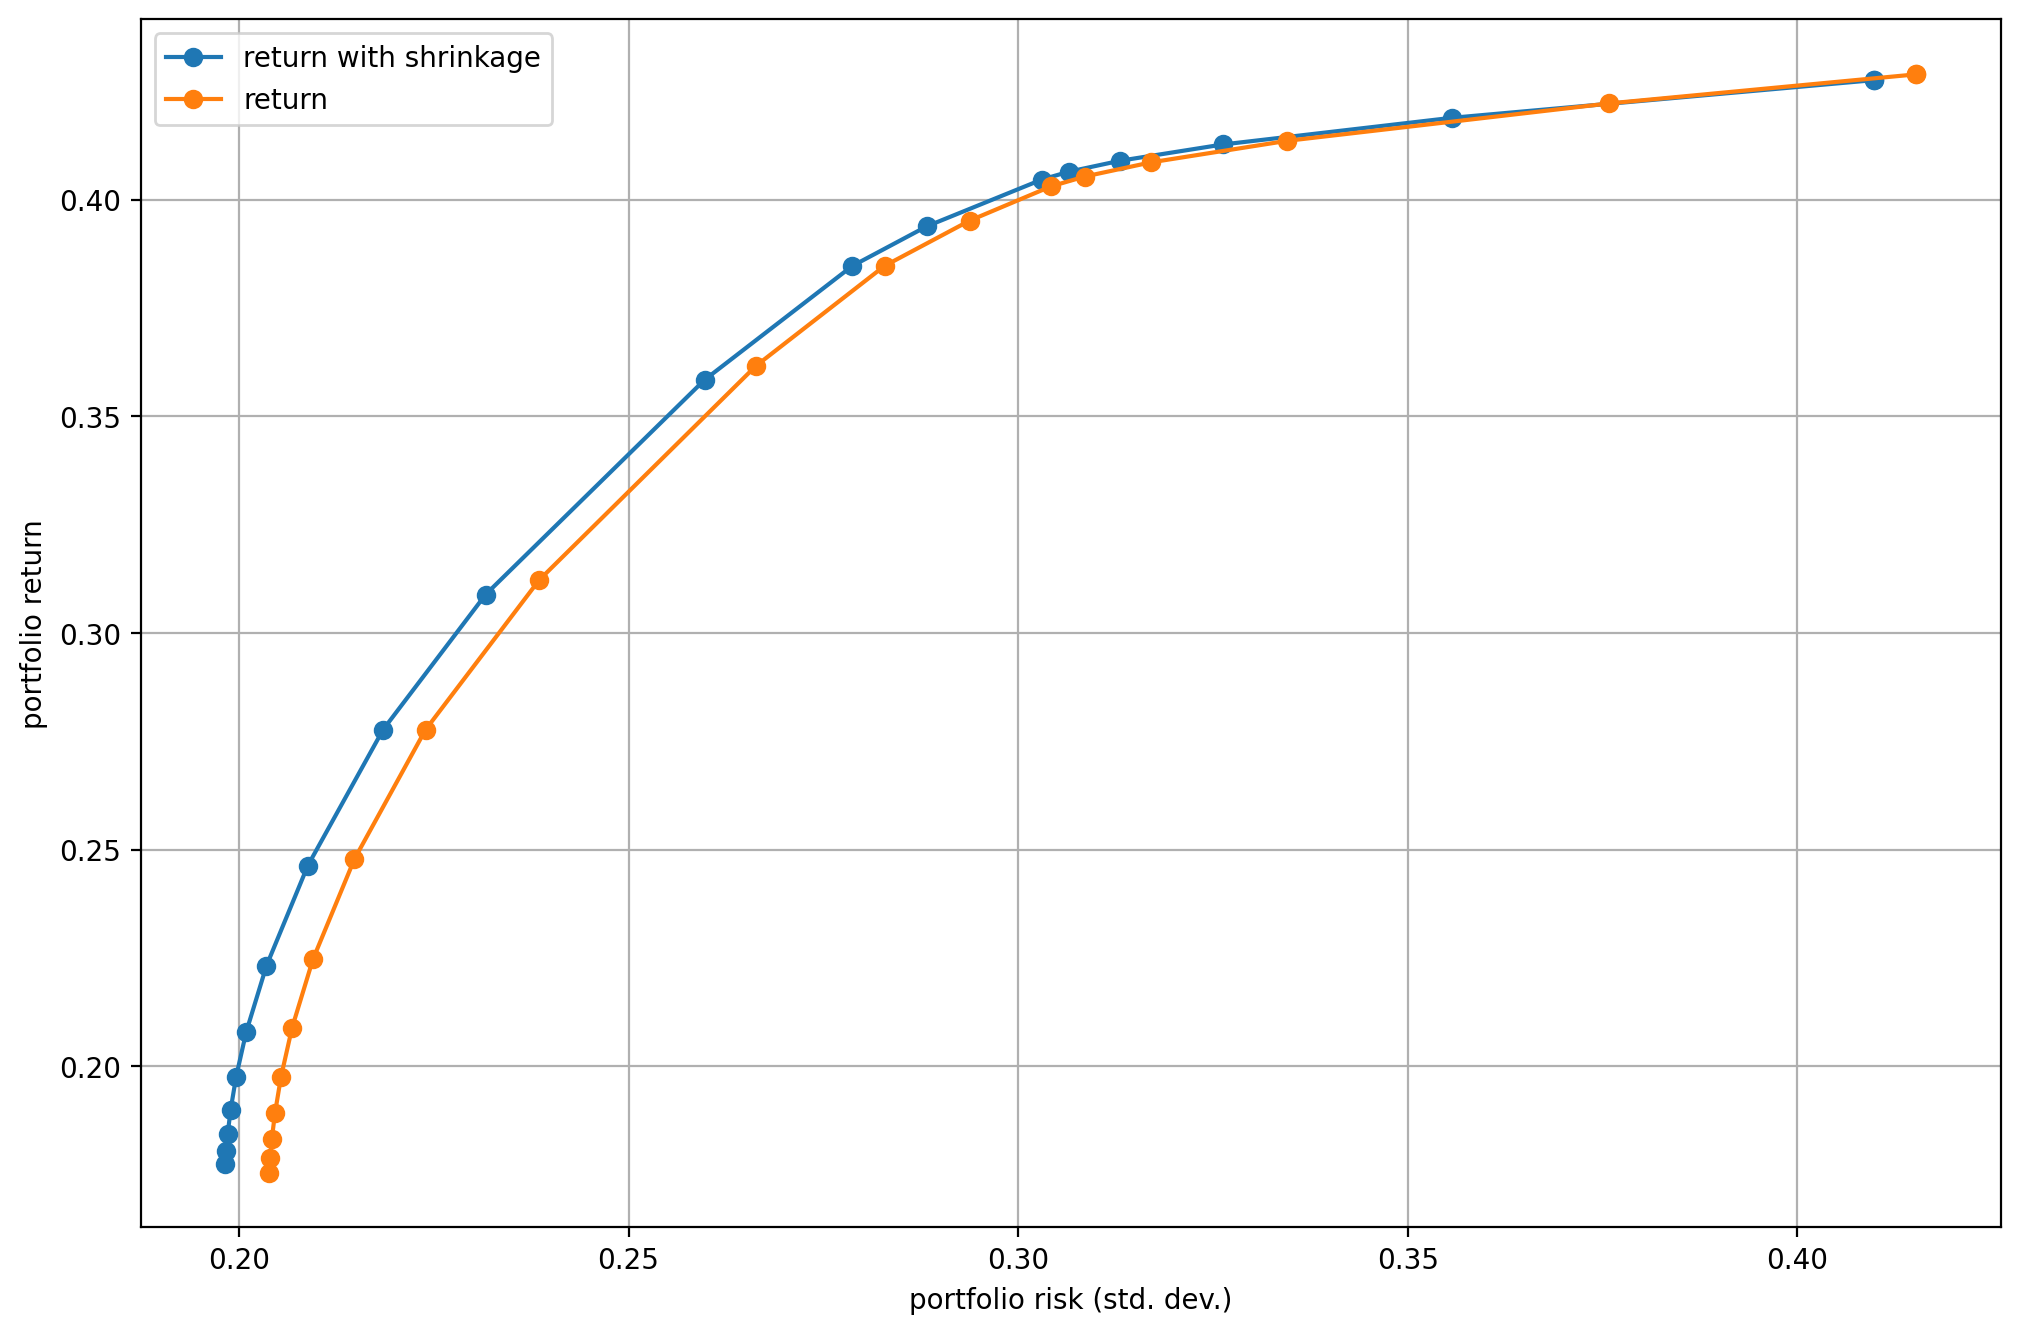

In [11]:
ax = df_result_shrunk.plot(x="risk", y="return", style="-o", xlabel="portfolio risk (std. dev.)", ylabel="portfolio return", grid=True)
df_result_orig.plot(ax=ax, x="risk", y="return", style="-o", xlabel="portfolio risk (std. dev.)", ylabel="portfolio return", grid=True)   
ax.legend(["return with shrinkage", "return"]);

Plot the portfolio composition for both cases.

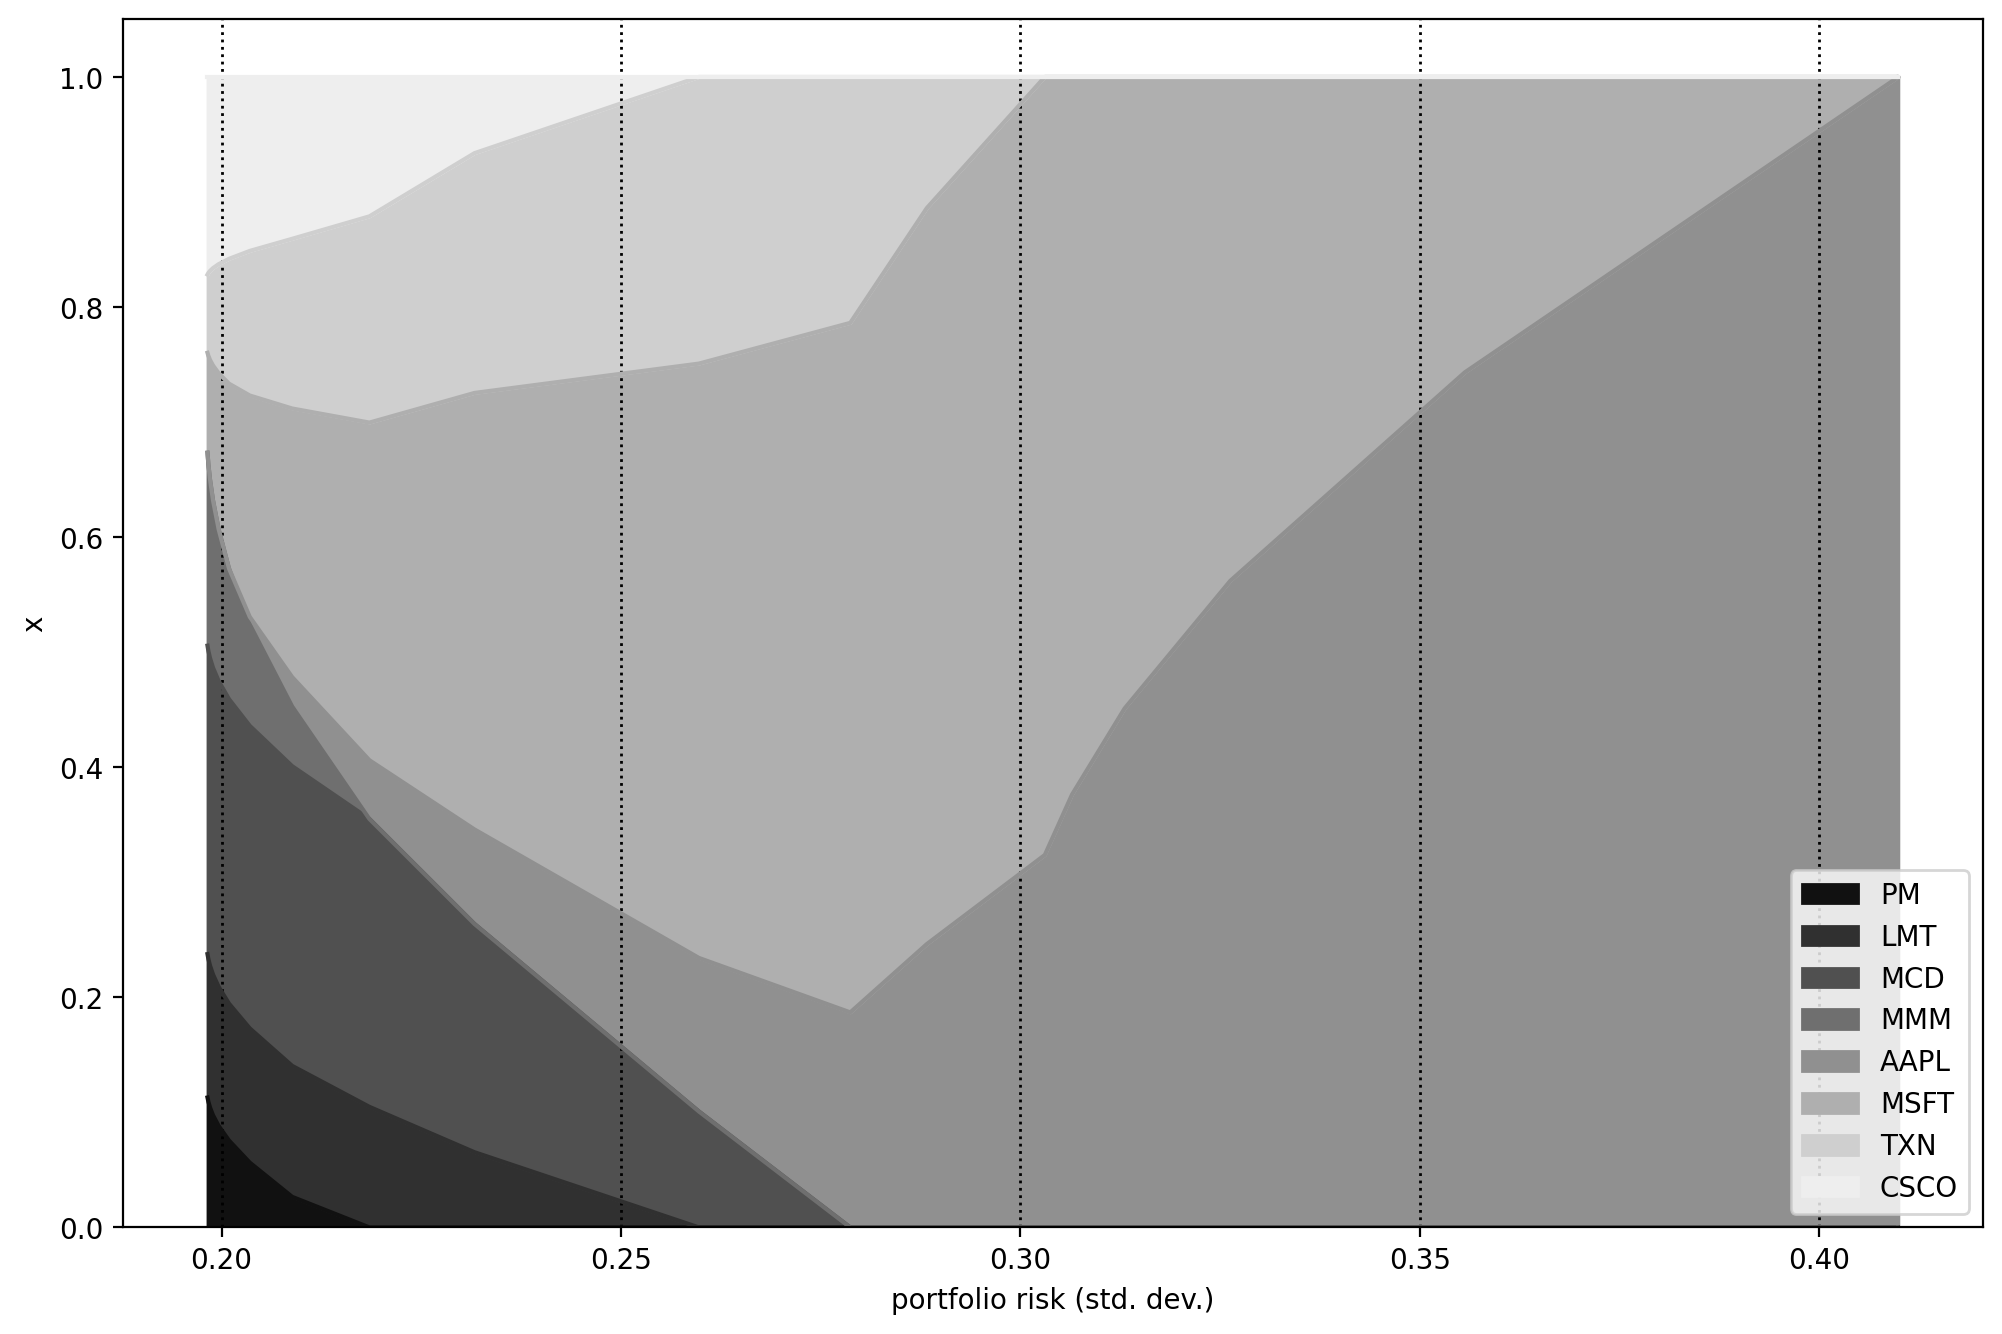

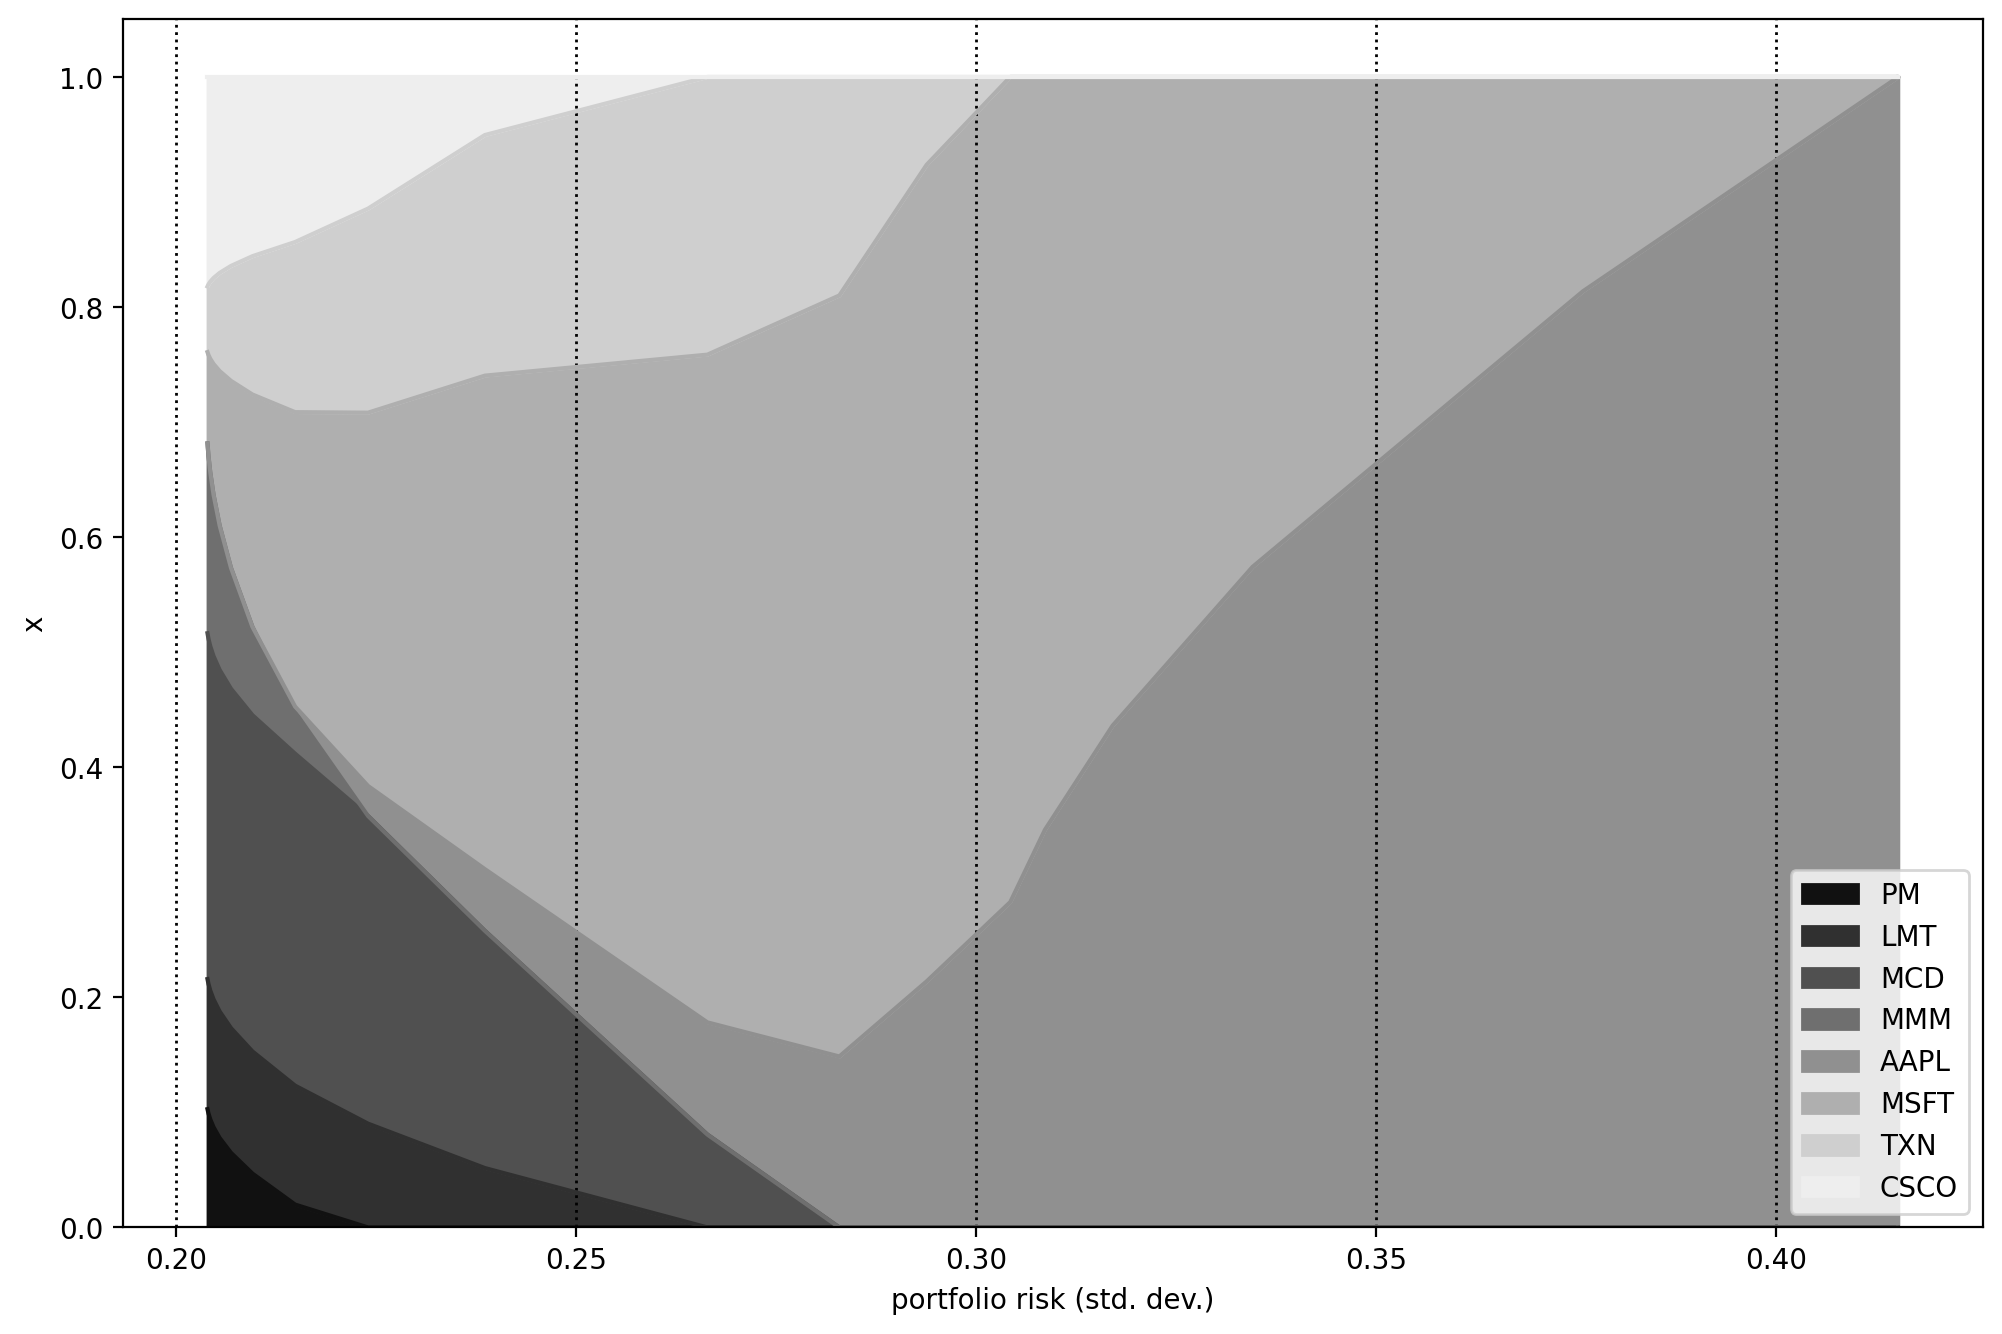

In [12]:
my_cmap = LinearSegmentedColormap.from_list("non-extreme gray", ["#111111", "#eeeeee"], N=256, gamma=1.0)
ax1 = df_result_shrunk.set_index('risk').iloc[:, 3:].plot.area(colormap=my_cmap, xlabel='portfolio risk (std. dev.)', ylabel="x")
ax1.grid(which='both', axis='x', linestyle=':', color='k', linewidth=1)
ax2 = df_result_orig.set_index('risk').iloc[:, 3:].plot.area(colormap=my_cmap, xlabel='portfolio risk (std. dev.)', ylabel="x") 
ax2.grid(which='both', axis='x', linestyle=':', color='k', linewidth=1)